# Fake Job Detector

## Importing Libraries

In [27]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.9 MB/s eta 0:00:00


In [60]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('stopwords')


stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading The Data

In [61]:
df = pd.read_csv("/content/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [62]:
df.shape

(17880, 18)

## Data PreProcessing

In [63]:
df_columns = df.columns.tolist()
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [64]:
dataTypeSeries = df.dtypes
print('Data type of each column of Dataframe :\n', dataTypeSeries)

Data type of each column of Dataframe :
 job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object


In [65]:
df[df_columns].isnull().sum()

,0
job_id,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
telecommuting,0


In [66]:
df = df.replace(np.nan, '', regex=True)

In [67]:
df["fraudulent"].value_counts()

,count
fraudulent,
0,17014
1,866


4.8434% (Approx 5%) Fake job post.


/tmp/ipython-input-1331831905.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='fraudulent', palette='Set2')


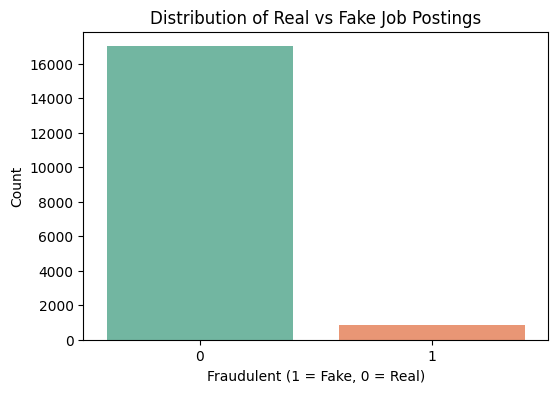

In [68]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='fraudulent', palette='Set2')
plt.title("Distribution of Real vs Fake Job Postings")
plt.xlabel("Fraudulent (1 = Fake, 0 = Real)")
plt.ylabel("Count")
plt.show()

In [69]:
df['text'] = df[['title', 'department','company_profile','description','requirements','benefits']].apply(lambda x: ' '.join(x), axis = 1)

In [70]:
df.text

,text
0,"Marketing Intern Marketing We're Food52, and w..."
1,Customer Service - Cloud Video Production Succ...
2,Commissioning Machinery Assistant (CMA) Valor...
3,Account Executive - Washington DC Sales Our pa...
4,Bill Review Manager SpotSource Solutions LLC ...
...,...
17875,Account Director - Distribution Sales Vend is...
17876,Payroll Accountant Accounting WebLinc is the e...
17877,Project Cost Control Staff Engineer - Cost Con...
17878,Graphic Designer Nemsia Studios is looking f...


In [71]:
df.drop(['job_id', 'location','title','salary_range' ,'department','salary_range','company_profile','description','requirements','benefits'], axis=1, inplace=True)

In [72]:
df_columns = df.columns.tolist()
df.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'text'],
      dtype='object')

In [73]:
from sklearn.preprocessing import LabelEncoder
label_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']
lb_make = LabelEncoder()
for i in label_columns:
  df[i] = lb_make.fit_transform(df[i])

In [74]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,1,0,3,5,0,0,23,0,"Marketing Intern Marketing We're Food52, and w..."
1,0,1,0,2,7,0,76,8,0,Customer Service - Cloud Video Production Succ...
2,0,1,0,0,0,0,0,0,0,Commissioning Machinery Assistant (CMA) Valor...
3,0,1,0,2,6,2,23,32,0,Account Executive - Washington DC Sales Our pa...
4,0,1,1,2,6,2,52,17,0,Bill Review Manager SpotSource Solutions LLC ...


In [75]:
df_columns = df_columns[-1:] + df_columns[:-1]
df = df[df_columns]
df.head()

,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,"Marketing Intern Marketing We're Food52, and w...",0,1,0,3,5,0,0,23,0
1,Customer Service - Cloud Video Production Succ...,0,1,0,2,7,0,76,8,0
2,Commissioning Machinery Assistant (CMA) Valor...,0,1,0,0,0,0,0,0,0
3,Account Executive - Washington DC Sales Our pa...,0,1,0,2,6,2,23,32,0
4,Bill Review Manager SpotSource Solutions LLC ...,0,1,1,2,6,2,52,17,0


In [76]:
def clean_text(text, ):
        if text is not None:
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
                text = re.sub(r'[0-9]+','',text)
                text =  text.lower()
                text = re.sub('re:', '', text)
                text = re.sub('-', '', text)
                text = re.sub('_', '', text)
                text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
                text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
        # Remove text between square brackets
                text =re.sub('\[[^]]*\]', '', text)
        # removes punctuation
                text = re.sub(r'[^\w\s]','',text)
                text = re.sub(r'\n',' ',text)
                text = re.sub(r'[0-9]+','',text)
        # strip html
                p = re.compile(r'<.*?>')
                text = re.sub(r"\'ve", " have ", text)
                text = re.sub(r"can't", "cannot ", text)
                text = re.sub(r"n't", " not ", text)
                text = re.sub(r"I'm", "I am", text)
                text = re.sub(r" m ", " am ", text)
                text = re.sub(r"\'re", " are ", text)
                text = re.sub(r"\'d", " would ", text)
                text = re.sub(r"\'ll", " will ", text)

                text = p.sub('', text)

        def tokenize_text(text,tokenizer=default_tokenizer):
            token = default_tokenizer.tokenize(text)
            return token

        def remove_stopwords(text, stop_words=default_stopwords):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        def stem_text(text, stemmer=default_stemmer):
            tokens = tokenize_text(text)
            return ' '.join([stemmer.stem(t) for t in tokens])

        text = stem_text(text) # stemming
        text = remove_stopwords(text) # remove stopwords
        #text.strip(' ') # strip whitespaces again?

        return text

In [77]:
df['text'] = df['text'].apply(clean_text)

In [78]:
df['text'].head()

,text
0,market intern market food weve creat groundbre...
1,custom servic cloud video product success seco...
2,commiss machineri assist cma valor servic prov...
3,account execut washington dc sale passion impr...
4,bill review manag spotsourc solut llc global h...


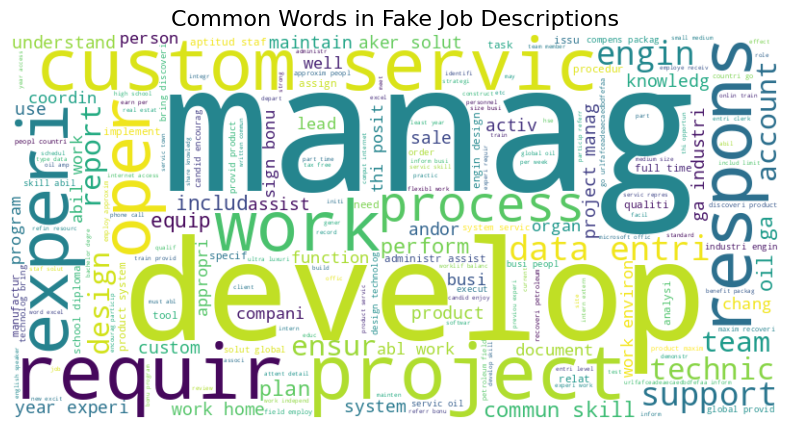

In [79]:
fake_text = " ".join(df[df['fraudulent'] == 1]['text'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Fake Job Descriptions", fontsize=16)
plt.show()


In [80]:
cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names_out())
df.drop(["text"], axis=1, inplace=True)
main_df = pd.concat([df1,df], axis=1)

In [81]:
main_df.head()

,abil,account,also,amp,applic,base,benefit,best,build,busi,...,year,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0.000000,0.000000,0.116434,0.102818,0.000000,0.000000,0.000000,0.119893,0.000000,0.091077,...,0.000000,0,1,0,3,5,0,0,23,0
1,0.000000,0.041469,0.033522,0.059203,0.000000,0.061404,0.000000,0.000000,0.000000,0.104886,...,0.000000,0,1,0,2,7,0,76,8,0
2,0.000000,0.000000,0.000000,0.092825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,1,0,0,0,0,0,0,0
3,0.039152,0.566401,0.000000,0.000000,0.000000,0.000000,0.089800,0.000000,0.118249,0.293025,...,0.058842,0,1,0,2,6,2,23,32,0
4,0.000000,0.109922,0.000000,0.000000,0.086042,0.000000,0.095852,0.182991,0.000000,0.069505,...,0.062808,0,1,1,2,6,2,52,17,0


In [82]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

## Data Splitting for Training and Fitting The Model

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(X_train,y_train)

## Score

In [84]:
model.score(X_train,y_train)

1.0

In [85]:
model.score(X_test,y_test)

0.9715883668903803

In [86]:
rfc_predict = model.predict(X_test)

In [87]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4247
           1       0.99      0.43      0.60       223

    accuracy                           0.97      4470
   macro avg       0.98      0.72      0.79      4470
weighted avg       0.97      0.97      0.97      4470



/tmp/ipython-input-384066199.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(main_df.columns)[indices], palette="viridis")


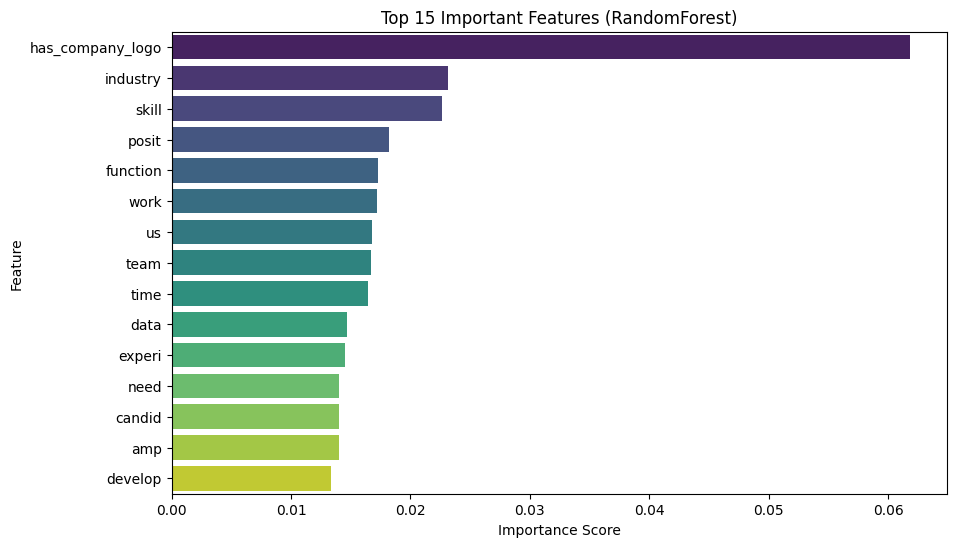

In [88]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(main_df.columns)[indices], palette="viridis")
plt.title("Top 15 Important Features (RandomForest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [89]:
cm = confusion_matrix(y_test, rfc_predict)

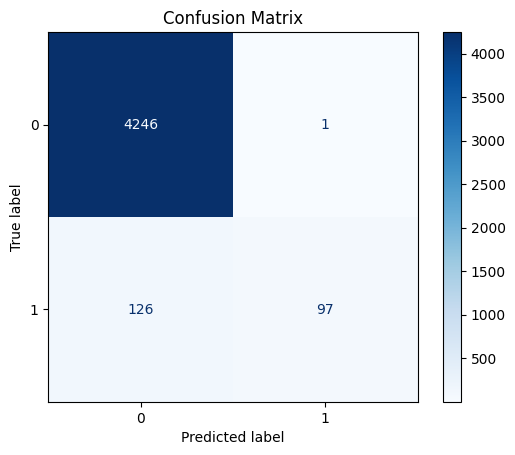

In [90]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Creating balance data for good recall and precision


In [91]:
smk  = SMOTETomek(random_state=42)
X_res, Y_res = smk.fit_resample(X, Y)

In [92]:
X_res.shape,Y_res.shape

((34016, 108), (34016,))

<Axes: ylabel='count'>

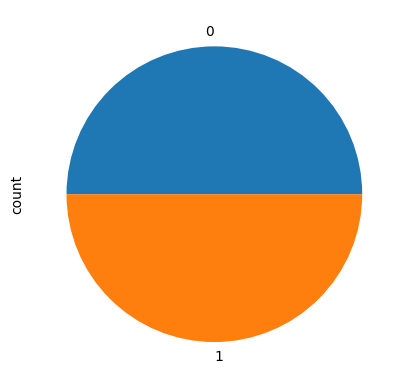

In [93]:
Y_res.value_counts().plot(kind="pie")

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_res,Y_res, test_size=0.25, random_state=42)
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(X_train,y_train)

## Evaluation

In [95]:
model.score(X_train,y_train)

1.0

In [96]:
model.score(X_test,y_test)

0.9932972718720602

In [97]:
rfc_predict = model.predict(X_test)

In [98]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4241
           1       0.99      0.99      0.99      4263

    accuracy                           0.99      8504
   macro avg       0.99      0.99      0.99      8504
weighted avg       0.99      0.99      0.99      8504



In [99]:
cm = confusion_matrix(y_test, rfc_predict)

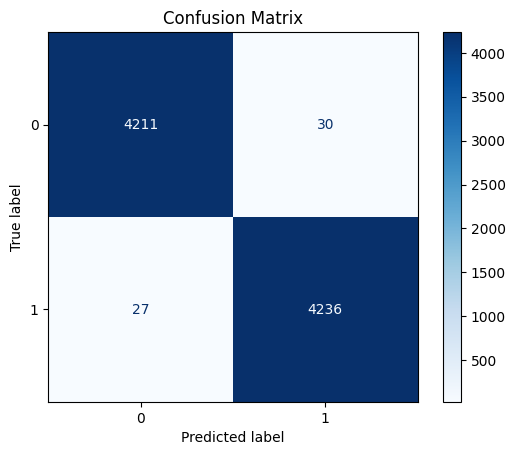

In [100]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Saving The Model

In [101]:
joblib.dump(model, "fake_job_rf_model.joblib")

['fake_job_rf_model.joblib']